In [ ]:
!pip install mip

In [ ]:
import numpy as np
from typing import List, Tuple, Dict, Set, Sequence, Optional
from collections import defaultdict
from mip import Model, xsum, BINARY, maximize, OptimizationStatus

# -----------------------------
# Reproducibility
# -----------------------------
np.random.seed(42)

# -----------------------------
# Types
# -----------------------------
Arc = Tuple[int, int]
Structure = Sequence[Arc]

# -----------------------------
# Instance generation (example)
# -----------------------------
num_vertices = 10
V = list(range(num_vertices))
A = [(i, j) for i in V for j in V if i != j and np.random.rand() < 0.3]  # random digraph (p=0.3)

# Success probabilities per arc
p = {(i, j): np.random.uniform(0.3, 0.9) for (i, j) in A}

# Crossmatch test budget
B = 15

# Scenarios (SAA: uniform weights)
num_scenarios = 50
S: List[Set[Arc]] = []
for _ in range(num_scenarios):
    scenario = set()
    for (i, j) in A:
        if np.random.rand() < p[(i, j)]:
            scenario.add((i, j))
    S.append(scenario)
qs = [1.0 / num_scenarios] * num_scenarios  # (not strictly needed below; we recompute uniform)

# -----------------------------
# Cycle / chain generation
# -----------------------------
def generate_cycles(V: List[int], A: List[Arc], K: int = 3, ndds: Optional[List[int]] = None) -> List[Structure]:
    """
    Generate simple directed cycles up to length K.
    If ndds is provided, exclude those vertices from cycle generation (typical KEP convention).
    """
    ndd_set = set(ndds or [])
    V_cyc = [v for v in V if v not in ndd_set]

    adj = defaultdict(list)
    A_set = set(A)
    for u, v in A:
        if u in V_cyc and v in V_cyc:  # keep arcs entirely within cycle-eligible vertices
            adj[u].append(v)

    found_vertices_cycles = set()

    def normalize_cycle(vertices: List[int]):
        k = len(vertices)
        i0 = min(range(k), key=lambda i: vertices[i])
        return tuple(vertices[i0:] + vertices[:i0])

    def dfs(start: int, path: List[int], visited: Set[int]):
        u = path[-1]
        if len(path) > K:
            return
        for w in adj.get(u, []):
            if w == start and len(path) >= 2:
                norm = normalize_cycle(path[:])
                found_vertices_cycles.add(norm)
            elif w not in visited and len(path) < K:
                visited.add(w)
                path.append(w)
                dfs(start, path, visited)
                path.pop()
                visited.remove(w)

    for s in V_cyc:
        dfs(s, [s], {s})

    cycles: List[Structure] = []
    for verts in found_vertices_cycles:
        k = len(verts)
        arcs = []
        ok = True
        for i in range(k):
            u, v = verts[i], verts[(i + 1) % k]
            if (u, v) not in A_set:
                ok = False
                break
            arcs.append((u, v))
        if ok:
            cycles.append(tuple(arcs))
    return cycles


def generate_chains(
    V: List[int], A: List[Arc], L: int = 0, ndds: Optional[List[int]] = None
) -> List[Structure]:
    """
    Generate simple directed chains starting from NDDs up to length L (number of arcs).
    If no NDDs or L<=0 -> return empty.
    """
    if not ndds or L <= 0:
        return []
    adj = defaultdict(list)
    A_set = set(A)
    for u, v in A:
        adj[u].append(v)

    chains: List[Structure] = []

    def dfs(u: int, path: List[int], visited: Set[int]):
        # path is a list of vertices; any path with len>=2 yields a chain (sequence of arcs)
        if len(path) >= 2:
            chains.append(tuple((path[i], path[i + 1]) for i in range(len(path) - 1)))
        if len(path) - 1 == L:  # already L arcs
            return
        for w in adj.get(u, []):
            if w not in visited:
                visited.add(w)
                path.append(w)
                dfs(w, path, visited)
                path.pop()
                visited.remove(w)

    for s in ndds:
        if s in V:
            dfs(s, [s], {s})
    chains = [h for h in chains if all(a in A_set for a in h)]
    return chains

# -----------------------------
# Solver
# -----------------------------
def solve_selection_problem(
    V: List[int],
    A: List[Arc],
    p: Dict[Arc, float],
    S: List[Set[Arc]],
    qs: List[float],
    B: int,
    K: int = 3,
    L: int = 0,
    ndds: Optional[List[int]] = None,
    cycles: Optional[List[Structure]] = None,
    chains: Optional[List[Structure]] = None,
    fallback_to_matching: bool = True,
):
    # --- Prep ---
    A_set = set(A)
    qs_use = [1.0 / len(S)] * len(S)  # SAA: equal scenario weights

    # Build cycles/chains if needed
    if cycles is None:
        cycles = generate_cycles(V, A, K, ndds=ndds)
        print(f"DEBUG: Generated Cycles: {len(cycles)}")
    if chains is None:
        chains = generate_chains(V, A, L, ndds)
        print(f"DEBUG: Generated Chains: {len(chains)}")

    # Safety: keep only structures fully within A
    cycles = [tuple(arcs) for arcs in cycles if all(a in A_set for a in arcs)]
    chains = [tuple(arcs) for arcs in chains if all(a in A_set for a in arcs)]
    print(f"DEBUG: Valid Cycles (subset of A): {len(cycles)}")
    print(f"DEBUG: Valid Chains (subset of A): {len(chains)}")

    # Quick feasibility scan across scenarios
    any_structure_feasible = False
    for scenario in S:
        feas_cycles = any(set(cyc).issubset(scenario) for cyc in cycles)
        feas_chains = any(set(ch).issubset(scenario) for ch in chains)
        if feas_cycles or feas_chains:
            any_structure_feasible = True
            break
    print(f"DEBUG: Is any structure feasible in at least one scenario? {any_structure_feasible}")

    # -----------------------------
    # Fallback: arc-matching model
    # -----------------------------
    if fallback_to_matching and not any_structure_feasible:
        print("DEBUG: Falling back to matching model...")
        m = Model(solver_name="CBC")  # <-- no sense here
        # First-stage: choose arcs to test
        beta = {arc: m.add_var(var_type=BINARY, name=f"beta_{arc[0]}_{arc[1]}") for arc in A}
        m += xsum(beta[arc] for arc in A) <= B

        # Scenario arc vars
        ys: Dict[Tuple[int, Arc], "mip.Var"] = {}
        for s_idx, scenario in enumerate(S):
            for arc in scenario:
                if arc in A_set:
                    ys[(s_idx, arc)] = m.add_var(var_type=BINARY, name=f"y_s{s_idx}_{arc[0]}_{arc[1]}")
                    # link: arc can be used only if tested
                    m += ys[(s_idx, arc)] <= beta[arc]

        # Node capacity per scenario (at most one incident arc)
        for s_idx, scenario in enumerate(S):
            scen_arcs = [arc for arc in scenario if arc in A_set]
            for v in V:
                inc_vars = [ys[(s_idx, a)] for a in scen_arcs if (s_idx, a) in ys and (a[0] == v or a[1] == v)]
                if inc_vars:
                    m += xsum(inc_vars) <= 1

        # Objective: expected realized arcs + tiny tie-breaker on beta
        eps = 1e-6
        main = xsum(
            (1.0 / len(S)) * xsum(ys[(s_idx, a)] for a in scenario if (s_idx, a) in ys)
            for s_idx, scenario in enumerate(S)
        )
        m.objective = maximize(main + eps * xsum(beta[a] for a in A))  # <-- MAXIMIZE!

        print("DEBUG: Optimizing fallback matching model...")
        status: OptimizationStatus = m.optimize(max_seconds=600)
        print(f"DEBUG: Fallback Matching Model Status: {status.name}")

        selected_arcs = [arc for arc in A if beta[arc].x is not None and beta[arc].x >= 0.99]
        print(f"DEBUG: Fallback Matching - Selected beta arcs count: {len(selected_arcs)}")
        print(f"DEBUG: Fallback Matching - Selected beta arcs (first 10): {selected_arcs[:10]}")

        chosen_structs_per_scenario = []
        for s_idx, scenario in enumerate(S):
            arcs_chosen = [arc for arc in scenario if (s_idx, arc) in ys and ys[(s_idx, arc)].x and ys[(s_idx, arc)].x >= 0.99]
            chosen_structs_per_scenario.append({"cycles": [], "chains": [], "arcs": arcs_chosen})
        print(f"DEBUG: Fallback Matching - Chosen arcs per scenario (first 3): {chosen_structs_per_scenario[:3]}")

        obj = m.objective_value if m.status in (OptimizationStatus.OPTIMAL, OptimizationStatus.FEASIBLE) else None
        return selected_arcs, chosen_structs_per_scenario, status.name, obj

    # -----------------------------
    # Structure-based (cycles/chains) model
    # -----------------------------
    print("DEBUG: Using structure-based model...")
    m = Model(solver_name="CBC")  # <-- no sense here

    # First stage: choose arcs to test
    beta = {arc: m.add_var(var_type=BINARY, name=f"beta_{arc[0]}_{arc[1]}") for arc in A}
    m += xsum(beta[arc] for arc in A) <= B

    # Recourse variables only for feasible structures in each scenario
    xs: Dict[Tuple[int, str, int], "mip.Var"] = {}
    feasible_structs_by_s: List[Tuple[List[int], List[int]]] = []

    for s_idx, scenario in enumerate(S):
        feas_cycles = [ci for ci, cyc in enumerate(cycles) if set(cyc).issubset(scenario)]
        feas_chains = [hi for hi, ch in enumerate(chains) if set(ch).issubset(scenario)]
        feasible_structs_by_s.append((feas_cycles, feas_chains))
        for ci in feas_cycles:
            xs[(s_idx, "C", ci)] = m.add_var(var_type=BINARY, name=f"x_s{s_idx}_C{ci}")
        for hi in feas_chains:
            xs[(s_idx, "H", hi)] = m.add_var(var_type=BINARY, name=f"x_s{s_idx}_H{hi}")

    print(f"DEBUG: Structure Model - Total xs variables created: {len(xs)}")

    # Per-structure, per-arc linking: x_{s,t} <= beta_a for all a in t
    for s_idx, scenario in enumerate(S):
        feas_cycles, feas_chains = feasible_structs_by_s[s_idx]
        for ci in feas_cycles:
            xi = xs[(s_idx, "C", ci)]
            for a in cycles[ci]:
                m += xi <= beta[a]
        for hi in feas_chains:
            xi = xs[(s_idx, "H", hi)]
            for a in chains[hi]:
                m += xi <= beta[a]

    # Vertex-disjointness per scenario
    def verts_of(struct: Structure) -> Set[int]:
        vs = set()
        for u, v in struct:
            vs.add(u); vs.add(v)
        return vs

    cycle_verts = [verts_of(c) for c in cycles]
    chain_verts = [verts_of(h) for h in chains]

    for s_idx, _ in enumerate(S):
        feas_cycles, feas_chains = feasible_structs_by_s[s_idx]
        for v in V:
            touch_vars = []
            for ci in feas_cycles:
                if v in cycle_verts[ci]:
                    touch_vars.append(xs[(s_idx, "C", ci)])
            for hi in feas_chains:
                if v in chain_verts[hi]:
                    touch_vars.append(xs[(s_idx, "H", hi)])
            if touch_vars:
                m += xsum(touch_vars) <= 1

    # Objective: expected number of transplants + tiny β tie-breaker
    def size_of(struct: Structure) -> int:
        return len(struct)

    main = xsum(
        (1.0 / len(S)) * (
            xsum(size_of(cycles[ci]) * xs[(s_idx, "C", ci)] for ci in feasible_structs_by_s[s_idx][0]) +
            xsum(size_of(chains[hi]) * xs[(s_idx, "H", hi)] for hi in feasible_structs_by_s[s_idx][1])
        )
        for s_idx in range(len(S))
    )
    eps = 1e-6
    m.objective = maximize(main + eps * xsum(beta[a] for a in A))  # <-- MAXIMIZE!

    print("DEBUG: Optimizing structure-based model...")
    status: OptimizationStatus = m.optimize(max_seconds=600)
    print(f"DEBUG: Structure Model Status: {status.name}")

    selected_arcs = [arc for arc in A if beta[arc].x is not None and beta[arc].x >= 0.99]
    print(f"DEBUG: Structure Model - Selected beta arcs count: {len(selected_arcs)}")
    print(f"DEBUG: Structure Model - Selected beta arcs (first 10): {selected_arcs[:10]}")

    chosen_structs_per_scenario = []
    for s_idx in range(len(S)):
        feas_cycles, feas_chains = feasible_structs_by_s[s_idx]
        chosen_cycles = [list(cycles[ci]) for ci in feas_cycles
                         if xs[(s_idx, "C", ci)].x is not None and xs[(s_idx, "C", ci)].x >= 0.99]
        chosen_chains = [list(chains[hi]) for hi in feas_chains
                         if xs[(s_idx, "H", hi)].x is not None and xs[(s_idx, "H", hi)].x >= 0.99]
        chosen_structs_per_scenario.append({"cycles": chosen_cycles, "chains": chosen_chains})
    print(f"DEBUG: Structure Model - Chosen structs per scenario (first 3): {chosen_structs_per_scenario[:3]}")

    obj = m.objective_value if m.status in (OptimizationStatus.OPTIMAL, OptimizationStatus.FEASIBLE) else None
    return selected_arcs, chosen_structs_per_scenario, status.name, obj


# -----------------------------
# Example run
# -----------------------------
if __name__ == "__main__":
    selected_arcs, structs_by_s, status, obj = solve_selection_problem(
        V, A, p, S, qs, B, K=3, L=3, ndds=[0, 1], fallback_to_matching=True
    )
    print(f"\n--- Final Results ---")
    print(f"Status: {status} | Objective: {obj}")
    print("Selected arcs:", selected_arcs[:20], ("..." if len(selected_arcs) > 20 else ""))
    for i in range(min(3, len(structs_by_s))):
        print(f"Scenario {i+1}:", structs_by_s[i])


DEBUG: Generated Cycles: 5
DEBUG: Generated Chains: 72
DEBUG: Valid Cycles (subset of A): 5
DEBUG: Valid Chains (subset of A): 72
DEBUG: Is any structure feasible in at least one scenario? True
DEBUG: Using structure-based model...
DEBUG: Structure Model - Total xs variables created: 1090
DEBUG: Optimizing structure-based model...
DEBUG: Structure Model Status: OPTIMAL
DEBUG: Structure Model - Selected beta arcs count: 15
DEBUG: Structure Model - Selected beta arcs (first 10): [(0, 6), (0, 7), (1, 5), (1, 7), (2, 4), (3, 6), (4, 5), (4, 9), (5, 4), (6, 3)]
DEBUG: Structure Model - Chosen structs per scenario (first 3): [{'cycles': [], 'chains': [[(0, 7), (7, 9), (9, 2)], [(1, 5)]]}, {'cycles': [], 'chains': [[(0, 6), (6, 8), (8, 5)], [(1, 7)]]}, {'cycles': [], 'chains': [[(0, 6), (6, 8), (8, 5)], [(1, 7), (7, 9), (9, 2)]]}]

--- Final Results ---
Status: OPTIMAL | Objective: 5.440014999999995
Selected arcs: [(0, 6), (0, 7), (1, 5), (1, 7), (2, 4), (3, 6), (4, 5), (4, 9), (5, 4), (6, 3)

DEBUG: Generated Cycles: 3
DEBUG: Generated Chains: 27
DEBUG: Valid Cycles (subset of A): 3
DEBUG: Valid Chains (subset of A): 27
DEBUG: Is any structure feasible in at least one scenario? True
DEBUG: Using structure-based model...
DEBUG: Structure Model - Total xs variables created: 1263
DEBUG: Optimizing structure-based model...
DEBUG: Structure Model Status: OPTIMAL
DEBUG: Structure Model - Selected beta arcs count: 31
DEBUG: Structure Model - Selected beta arcs (first 10): [(0, 5), (0, 6), (0, 7), (1, 2), (1, 5), (1, 6), (1, 7), (2, 1), (2, 4), (2, 5)]
DEBUG: Structure Model - Chosen structs per scenario (first 3): [{'cycles': [[(2, 9), (9, 2)]], 'chains': [[(0, 7), (7, 3)], [(1, 5)]]}, {'cycles': [], 'chains': [[(0, 6), (6, 2)], [(1, 7), (7, 5)]]}, {'cycles': [], 'chains': [[(0, 6), (6, 2)], [(1, 5), (5, 4)]]}]

--- Final Results ---
Status: OPTIMAL | Objective: 4.900030999999982
Selected arcs: [(0, 5), (0, 6), (0, 7), (1, 2), (1, 5), (1, 6), (1, 7), (2, 1), (2, 4), (2, 5), (2, 9)

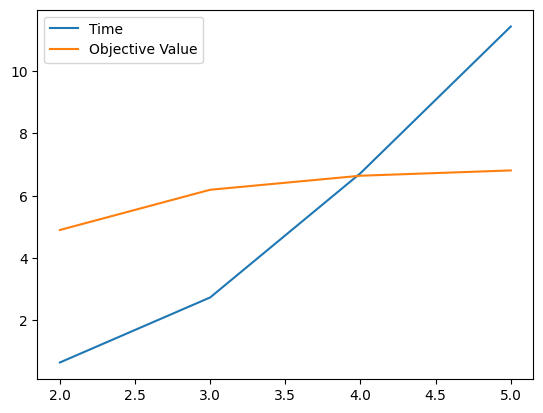

In [ ]:
import time
import numpy as np
from typing import List, Tuple, Dict, Set, Sequence, Optional
from collections import defaultdict
from mip import Model, xsum, BINARY, maximize, OptimizationStatus
results=[]
for k in range(2,6):
  us=[]
  for u in range(5):
    t1=time.time()
    np.random.seed(42)

    # -----------------------------
    # Types
    # -----------------------------
    Arc = Tuple[int, int]
    Structure = Sequence[Arc]
    num_vertices = 10
    V = list(range(num_vertices))
    A = [(i, j) for i in V for j in V if i != j and np.random.rand() < 0.3]  # random digraph (p=0.3)

    # Success probabilities per arc
    p = {(i, j): np.random.uniform(0.3, 0.9) for (i, j) in A}

    # Crossmatch test budget
    B = num_vertices*(num_vertices)/3

    # Scenarios (SAA: uniform weights)
    num_scenarios = 100
    S: List[Set[Arc]] = []
    for _ in range(num_scenarios):
        scenario = set()
        for (i, j) in A:
            if np.random.rand() < p[(i, j)]:
                scenario.add((i, j))
        S.append(scenario)
    qs = [1.0 / num_scenarios] * num_scenarios  # (not strictly needed below; we recompute uniform)

    # -----------------------------
    # Cycle / chain generation
    # -----------------------------
    def generate_cycles(V: List[int], A: List[Arc], K: int = 3, ndds: Optional[List[int]] = None) -> List[Structure]:
        """
        Generate simple directed cycles up to length K.
        If ndds is provided, exclude those vertices from cycle generation (typical KEP convention).
        """
        ndd_set = set(ndds or [])
        V_cyc = [v for v in V if v not in ndd_set]

        adj = defaultdict(list)
        A_set = set(A)
        for u, v in A:
            if u in V_cyc and v in V_cyc:  # keep arcs entirely within cycle-eligible vertices
                adj[u].append(v)

        found_vertices_cycles = set()

        def normalize_cycle(vertices: List[int]):
            k = len(vertices)
            i0 = min(range(k), key=lambda i: vertices[i])
            return tuple(vertices[i0:] + vertices[:i0])

        def dfs(start: int, path: List[int], visited: Set[int]):
            u = path[-1]
            if len(path) > K:
                return
            for w in adj.get(u, []):
                if w == start and len(path) >= 2:
                    norm = normalize_cycle(path[:])
                    found_vertices_cycles.add(norm)
                elif w not in visited and len(path) < K:
                    visited.add(w)
                    path.append(w)
                    dfs(start, path, visited)
                    path.pop()
                    visited.remove(w)

        for s in V_cyc:
            dfs(s, [s], {s})

        cycles: List[Structure] = []
        for verts in found_vertices_cycles:
            k = len(verts)
            arcs = []
            ok = True
            for i in range(k):
                u, v = verts[i], verts[(i + 1) % k]
                if (u, v) not in A_set:
                    ok = False
                    break
                arcs.append((u, v))
            if ok:
                cycles.append(tuple(arcs))
        return cycles


    def generate_chains(
        V: List[int], A: List[Arc], L: int = 0, ndds: Optional[List[int]] = None
    ) -> List[Structure]:
        """
        Generate simple directed chains starting from NDDs up to length L (number of arcs).
        If no NDDs or L<=0 -> return empty.
        """
        if not ndds or L <= 0:
            return []
        adj = defaultdict(list)
        A_set = set(A)
        for u, v in A:
            adj[u].append(v)

        chains: List[Structure] = []

        def dfs(u: int, path: List[int], visited: Set[int]):
            # path is a list of vertices; any path with len>=2 yields a chain (sequence of arcs)
            if len(path) >= 2:
                chains.append(tuple((path[i], path[i + 1]) for i in range(len(path) - 1)))
            if len(path) - 1 == L:  # already L arcs
                return
            for w in adj.get(u, []):
                if w not in visited:
                    visited.add(w)
                    path.append(w)
                    dfs(w, path, visited)
                    path.pop()
                    visited.remove(w)

        for s in ndds:
            if s in V:
                dfs(s, [s], {s})
        chains = [h for h in chains if all(a in A_set for a in h)]
        return chains

    # -----------------------------
    # Solver
    # -----------------------------
    def solve_selection_problem(
        V: List[int],
        A: List[Arc],
        p: Dict[Arc, float],
        S: List[Set[Arc]],
        qs: List[float],
        B: int,
        K: int = 3,
        L: int = 0,
        ndds: Optional[List[int]] = None,
        cycles: Optional[List[Structure]] = None,
        chains: Optional[List[Structure]] = None,
        fallback_to_matching: bool = True,
    ):
        # --- Prep ---
        A_set = set(A)
        qs_use = [1.0 / len(S)] * len(S)  # SAA: equal scenario weights

        # Build cycles/chains if needed
        if cycles is None:
            cycles = generate_cycles(V, A, K, ndds=ndds)
            print(f"DEBUG: Generated Cycles: {len(cycles)}")
        if chains is None:
            chains = generate_chains(V, A, L, ndds)
            print(f"DEBUG: Generated Chains: {len(chains)}")

        # Safety: keep only structures fully within A
        cycles = [tuple(arcs) for arcs in cycles if all(a in A_set for a in arcs)]
        chains = [tuple(arcs) for arcs in chains if all(a in A_set for a in arcs)]
        print(f"DEBUG: Valid Cycles (subset of A): {len(cycles)}")
        print(f"DEBUG: Valid Chains (subset of A): {len(chains)}")

        # Quick feasibility scan across scenarios
        any_structure_feasible = False
        for scenario in S:
            feas_cycles = any(set(cyc).issubset(scenario) for cyc in cycles)
            feas_chains = any(set(ch).issubset(scenario) for ch in chains)
            if feas_cycles or feas_chains:
                any_structure_feasible = True
                break
        print(f"DEBUG: Is any structure feasible in at least one scenario? {any_structure_feasible}")

        # -----------------------------
        # Fallback: arc-matching model
        # -----------------------------
        if fallback_to_matching and not any_structure_feasible:
            print("DEBUG: Falling back to matching model...")
            m = Model(solver_name="CBC")  # <-- no sense here
            # First-stage: choose arcs to test
            beta = {arc: m.add_var(var_type=BINARY, name=f"beta_{arc[0]}_{arc[1]}") for arc in A}
            m += xsum(beta[arc] for arc in A) <= B

            # Scenario arc vars
            ys: Dict[Tuple[int, Arc], "mip.Var"] = {}
            for s_idx, scenario in enumerate(S):
                for arc in scenario:
                    if arc in A_set:
                        ys[(s_idx, arc)] = m.add_var(var_type=BINARY, name=f"y_s{s_idx}_{arc[0]}_{arc[1]}")
                        # link: arc can be used only if tested
                        m += ys[(s_idx, arc)] <= beta[arc]

            # Node capacity per scenario (at most one incident arc)
            for s_idx, scenario in enumerate(S):
                scen_arcs = [arc for arc in scenario if arc in A_set]
                for v in V:
                    inc_vars = [ys[(s_idx, a)] for a in scen_arcs if (s_idx, a) in ys and (a[0] == v or a[1] == v)]
                    if inc_vars:
                        m += xsum(inc_vars) <= 1

            # Objective: expected realized arcs + tiny tie-breaker on beta
            eps = 1e-6
            main = xsum(
                (1.0 / len(S)) * xsum(ys[(s_idx, a)] for a in scenario if (s_idx, a) in ys)
                for s_idx, scenario in enumerate(S)
            )
            m.objective = maximize(main + eps * xsum(beta[a] for a in A))  # <-- MAXIMIZE!

            print("DEBUG: Optimizing fallback matching model...")
            status: OptimizationStatus = m.optimize(max_seconds=600)
            print(f"DEBUG: Fallback Matching Model Status: {status.name}")

            selected_arcs = [arc for arc in A if beta[arc].x is not None and beta[arc].x >= 0.99]
            print(f"DEBUG: Fallback Matching - Selected beta arcs count: {len(selected_arcs)}")
            print(f"DEBUG: Fallback Matching - Selected beta arcs (first 10): {selected_arcs[:10]}")

            chosen_structs_per_scenario = []
            for s_idx, scenario in enumerate(S):
                arcs_chosen = [arc for arc in scenario if (s_idx, arc) in ys and ys[(s_idx, arc)].x and ys[(s_idx, arc)].x >= 0.99]
                chosen_structs_per_scenario.append({"cycles": [], "chains": [], "arcs": arcs_chosen})
            print(f"DEBUG: Fallback Matching - Chosen arcs per scenario (first 3): {chosen_structs_per_scenario[:3]}")

            obj = m.objective_value if m.status in (OptimizationStatus.OPTIMAL, OptimizationStatus.FEASIBLE) else None
            return selected_arcs, chosen_structs_per_scenario, status.name, obj

        # -----------------------------
        # Structure-based (cycles/chains) model
        # -----------------------------
        print("DEBUG: Using structure-based model...")
        m = Model(solver_name="CBC")  # <-- no sense here

        # First stage: choose arcs to test
        beta = {arc: m.add_var(var_type=BINARY, name=f"beta_{arc[0]}_{arc[1]}") for arc in A}
        m += xsum(beta[arc] for arc in A) <= B

        # Recourse variables only for feasible structures in each scenario
        xs: Dict[Tuple[int, str, int], "mip.Var"] = {}
        feasible_structs_by_s: List[Tuple[List[int], List[int]]] = []

        for s_idx, scenario in enumerate(S):
            feas_cycles = [ci for ci, cyc in enumerate(cycles) if set(cyc).issubset(scenario)]
            feas_chains = [hi for hi, ch in enumerate(chains) if set(ch).issubset(scenario)]
            feasible_structs_by_s.append((feas_cycles, feas_chains))
            for ci in feas_cycles:
                xs[(s_idx, "C", ci)] = m.add_var(var_type=BINARY, name=f"x_s{s_idx}_C{ci}")
            for hi in feas_chains:
                xs[(s_idx, "H", hi)] = m.add_var(var_type=BINARY, name=f"x_s{s_idx}_H{hi}")

        print(f"DEBUG: Structure Model - Total xs variables created: {len(xs)}")

        # Per-structure, per-arc linking: x_{s,t} <= beta_a for all a in t
        for s_idx, scenario in enumerate(S):
            feas_cycles, feas_chains = feasible_structs_by_s[s_idx]
            for ci in feas_cycles:
                xi = xs[(s_idx, "C", ci)]
                for a in cycles[ci]:
                    m += xi <= beta[a]
            for hi in feas_chains:
                xi = xs[(s_idx, "H", hi)]
                for a in chains[hi]:
                    m += xi <= beta[a]

        # Vertex-disjointness per scenario
        def verts_of(struct: Structure) -> Set[int]:
            vs = set()
            for u, v in struct:
                vs.add(u); vs.add(v)
            return vs

        cycle_verts = [verts_of(c) for c in cycles]
        chain_verts = [verts_of(h) for h in chains]

        for s_idx, _ in enumerate(S):
            feas_cycles, feas_chains = feasible_structs_by_s[s_idx]
            for v in V:
                touch_vars = []
                for ci in feas_cycles:
                    if v in cycle_verts[ci]:
                        touch_vars.append(xs[(s_idx, "C", ci)])
                for hi in feas_chains:
                    if v in chain_verts[hi]:
                        touch_vars.append(xs[(s_idx, "H", hi)])
                if touch_vars:
                    m += xsum(touch_vars) <= 1

        # Objective: expected number of transplants + tiny β tie-breaker
        def size_of(struct: Structure) -> int:
            return len(struct)

        main = xsum(
            (1.0 / len(S)) * (
                xsum(size_of(cycles[ci]) * xs[(s_idx, "C", ci)] for ci in feasible_structs_by_s[s_idx][0]) +
                xsum(size_of(chains[hi]) * xs[(s_idx, "H", hi)] for hi in feasible_structs_by_s[s_idx][1])
            )
            for s_idx in range(len(S))
        )
        eps = 1e-6
        m.objective = maximize(main + eps * xsum(beta[a] for a in A))  # <-- MAXIMIZE!

        print("DEBUG: Optimizing structure-based model...")
        status: OptimizationStatus = m.optimize(max_seconds=600)
        print(f"DEBUG: Structure Model Status: {status.name}")

        selected_arcs = [arc for arc in A if beta[arc].x is not None and beta[arc].x >= 0.99]
        print(f"DEBUG: Structure Model - Selected beta arcs count: {len(selected_arcs)}")
        print(f"DEBUG: Structure Model - Selected beta arcs (first 10): {selected_arcs[:10]}")

        chosen_structs_per_scenario = []
        for s_idx in range(len(S)):
            feas_cycles, feas_chains = feasible_structs_by_s[s_idx]
            chosen_cycles = [list(cycles[ci]) for ci in feas_cycles
                            if xs[(s_idx, "C", ci)].x is not None and xs[(s_idx, "C", ci)].x >= 0.99]
            chosen_chains = [list(chains[hi]) for hi in feas_chains
                            if xs[(s_idx, "H", hi)].x is not None and xs[(s_idx, "H", hi)].x >= 0.99]
            chosen_structs_per_scenario.append({"cycles": chosen_cycles, "chains": chosen_chains})
        print(f"DEBUG: Structure Model - Chosen structs per scenario (first 3): {chosen_structs_per_scenario[:3]}")

        obj = m.objective_value if m.status in (OptimizationStatus.OPTIMAL, OptimizationStatus.FEASIBLE) else None
        return selected_arcs, chosen_structs_per_scenario, status.name, obj


    # -----------------------------
    # Example run
    # -----------------------------
    if __name__ == "__main__":
        selected_arcs, structs_by_s, status, obj = solve_selection_problem(
            V, A, p, S, qs, B, K=k, L=k, ndds=[0, 1], fallback_to_matching=True
        )
        print(f"\n--- Final Results ---")
        print(f"Status: {status} | Objective: {obj}")
        print("Selected arcs:", selected_arcs[:20], ("..." if len(selected_arcs) > 20 else ""))
        for i in range(min(3, len(structs_by_s))):
            print(f"Scenario {i+1}:", structs_by_s[i])
        print('----------------------------------------------------')
    t2=time.time()
    dt=t2-t1
    us.append((dt,obj))
  dts=[U[1] for U in us]
  objs=[U[0] for U in us]
  dt,obj = sum(dts)/5 , sum(objs)/5
  results.append((obj,dt))
dts=[r[0] for r in results]
objs=[r[1] for r in results]
plt.plot([2,3,4,5],dts,label='Time')
plt.plot([2,3,4,5],objs,label='Objective Value')
plt.legend()
plt.show()